In [95]:
import pandas as pd

# Load your dataset
df = pd.read_csv("daily_mov.csv", parse_dates=["date"])

# Sort by user and date for proper time-series operations
df.sort_values(by=["user_id", "date"], inplace=True)

# Extract 'day' and 'month' from 'date'
df["day"] = df["date"].dt.day
df["month"] = df["date"].dt.month

# Yesterday's mood
#df["mood_yesterday"] = df.groupby("user_id")["mood"].shift(1)

# Average mood over last 5 days
df["mood_avg_5d"] = (
    df.groupby("user_id")["mood"]
    .rolling(window=5, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)

# Mood change from yesterday to today
#df["mood_change"] = df["mood"] - df["mood_yesterday"]

# One-hot encode the 'weekday' column
weekday_dummies = pd.get_dummies(df["weekday"], prefix="weekday")
df = pd.concat([df, weekday_dummies], axis=1)

# Drop columns: id, date, total_entries
df.drop(columns=["id", "date", "total_entries"], inplace=True)

# Save the modified dataset
df.to_csv("daily_mov_featured.csv", index=False)

print("✅ Done! Features updated and saved to 'daily_mov_featured.csv'")


✅ Done! Features updated and saved to 'daily_mov_featured.csv'


In [96]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

feature_cols = [
    'screen','call','sms','appCat.builtin','appCat.communication','appCat.entertainment',
    'appCat.finance','appCat.game','appCat.office','appCat.other','appCat.social',
    'appCat.travel','appCat.unknown','appCat.utilities','appCat.weather','activity',
    'circumplex.arousal','circumplex.valence','mood_count',
    'weekday','day','month','weekday_0','weekday_1','weekday_2','weekday_3','weekday_4','weekday_5','weekday_6'
]

# Load dataset
df = pd.read_csv("daily_mov_featured.csv")
target = 'mood'
user_col = 'user_id'

# Normalize features
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

# Encode user_id
df['user_id_idx'] = df[user_col].astype('category').cat.codes
num_users = df['user_id_idx'].nunique()

# Train/validation/test split
train_val_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.3, random_state=42)

# PyTorch Dataset
class MoodDataset(Dataset):
    def __init__(self, dataframe):
        self.features = dataframe[feature_cols].values.astype('float32')
        self.moods = dataframe[target].values.astype('float32')
        self.user_ids = dataframe['user_id_idx'].values.astype('int64')

    def __len__(self):
        return len(self.moods)

    def __getitem__(self, idx):
        return {
            'features': torch.tensor(self.features[idx]),
            'user_id': torch.tensor(self.user_ids[idx]),
            'mood': torch.tensor(self.moods[idx]),
            'raw_user_id': int(self.user_ids[idx])
        }

# Create DataLoaders
train_loader = DataLoader(MoodDataset(train_df), batch_size=32, shuffle=True)
val_loader = DataLoader(MoodDataset(val_df), batch_size=32)
test_loader = DataLoader(MoodDataset(test_df), batch_size=32)

# Neural Network
class MoodNN(nn.Module):
    def __init__(self, input_dim, num_users, user_emb_dim=16):
        super(MoodNN, self).__init__()
        self.user_embedding = nn.Embedding(num_users, user_emb_dim)
        self.fc = nn.Sequential(
            nn.Linear(input_dim + user_emb_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )

    def forward(self, x, user_id):
        user_emb = self.user_embedding(user_id)
        x = torch.cat([x, user_emb], dim=1)
        return self.fc(x)

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.best_model_state = None

    def step(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MoodNN(input_dim=len(feature_cols), num_users=num_users).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
loss_fn = nn.MSELoss()
early_stopper = EarlyStopping(patience=5)

# Training loop with validation and early stopping
for epoch in range(100):
    model.train()
    total_loss = 0
    for batch in train_loader:
        x = batch['features'].to(device)
        user_id = batch['user_id'].to(device)
        y = batch['mood'].to(device).unsqueeze(1)

        optimizer.zero_grad()
        pred = model(x, user_id)
        loss = loss_fn(pred, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        total_loss += loss.item()

    # Validation loss
    model.eval()
    val_preds, val_actuals = [], []
    with torch.no_grad():
        for batch in val_loader:
            x = batch['features'].to(device)
            user_id = batch['user_id'].to(device)
            y = batch['mood'].to(device).unsqueeze(1)
            pred = model(x, user_id)
            val_preds.extend(pred.cpu().numpy())
            val_actuals.extend(y.cpu().numpy())

    val_loss = mean_squared_error(val_actuals, val_preds, squared=False)
    print(f"Epoch {epoch+1} - Train Loss: {total_loss / len(train_loader):.4f}, Val RMSE: {val_loss:.4f}")

    if early_stopper.step(val_loss, model):
        print("🛑 Early stopping triggered.")
        model.load_state_dict(early_stopper.best_model_state)
        break

# Evaluation
model.eval()
preds, actuals, user_ids = [], [], []
with torch.no_grad():
    for batch in test_loader:
        x = batch['features'].to(device)
        user_id = batch['user_id'].to(device)
        y = batch['mood'].to(device).unsqueeze(1)
        raw_user_ids = batch['raw_user_id']
        pred = model(x, user_id)

        preds.extend(pred.cpu().numpy())
        actuals.extend(y.cpu().numpy())
        user_ids.extend(raw_user_ids)

preds = np.array(preds).flatten()
actuals = np.array(actuals).flatten()
user_ids = np.array(user_ids)
mask = np.isfinite(preds) & np.isfinite(actuals)
preds = preds[mask]
actuals = actuals[mask]
user_ids = user_ids[mask]

print(f"✅ Prediction count: {len(preds)}, Actual count: {len(actuals)}")

if len(preds) > 0:
    r2 = r2_score(actuals, preds)
    rmse = mean_squared_error(actuals, preds, squared=False)
    accuracy = np.mean(np.round(preds) == np.round(actuals))  # raw rounding accuracy
    print(f"\n✅ Test RMSE: {rmse:.4f}, R²: {r2:.4f}, Accuracy (rounded match): {accuracy:.4f}")

    user_results = defaultdict(list)
    for uid, pred, actual in zip(user_ids, preds, actuals):
        user_results[uid].append((pred, actual))

    print("\n📊 Per-User Accuracy:")
    for uid, values in user_results.items():
        pred_vals, actual_vals = zip(*values)
        acc = np.mean(np.round(pred_vals) == np.round(actual_vals))
        print(f"  User {uid}: Rounded Accuracy = {acc:.2f} ({len(values)} samples)")
        for i, (p, a) in enumerate(values):
            print(f"    Sample {i+1}: Predicted = {p:.2f}, Actual = {a:.2f}")
else:
    print("❌ No valid predictions to evaluate.")


    # Save predictions to a DataFrame
results_df = pd.DataFrame({
    'user_id': user_ids,
    'predicted_mood': preds,
    'actual_mood': actuals,
    'predicted_mood_rounded': np.round(preds),
    'actual_mood_rounded': np.round(actuals)
})

# Save to CSV
results_df.to_csv("mood_predictions.csv", index=False)
print("📁 Predictions saved to mood_predictions.csv")

# Optional preview
print("\n🔍 Sample predictions:")
print(results_df.head())



Epoch 1 - Train Loss: 0.1433, Val RMSE: 0.2391
Epoch 2 - Train Loss: 0.0649, Val RMSE: 0.2233
Epoch 3 - Train Loss: 0.0524, Val RMSE: 0.2126
Epoch 4 - Train Loss: 0.0499, Val RMSE: 0.2047
Epoch 5 - Train Loss: 0.0477, Val RMSE: 0.1877
Epoch 6 - Train Loss: 0.0369, Val RMSE: 0.1797
Epoch 7 - Train Loss: 0.0369, Val RMSE: 0.1722
Epoch 8 - Train Loss: 0.0400, Val RMSE: 0.1667
Epoch 9 - Train Loss: 0.0328, Val RMSE: 0.1692
Epoch 10 - Train Loss: 0.0323, Val RMSE: 0.1635
Epoch 11 - Train Loss: 0.0278, Val RMSE: 0.1621
Epoch 12 - Train Loss: 0.0273, Val RMSE: 0.1606
Epoch 13 - Train Loss: 0.0285, Val RMSE: 0.1574
Epoch 14 - Train Loss: 0.0271, Val RMSE: 0.1533
Epoch 15 - Train Loss: 0.0248, Val RMSE: 0.1515
Epoch 16 - Train Loss: 0.0249, Val RMSE: 0.1476
Epoch 17 - Train Loss: 0.0247, Val RMSE: 0.1455
Epoch 18 - Train Loss: 0.0230, Val RMSE: 0.1445
Epoch 19 - Train Loss: 0.0222, Val RMSE: 0.1439
Epoch 20 - Train Loss: 0.0215, Val RMSE: 0.1444
Epoch 21 - Train Loss: 0.0240, Val RMSE: 0.1440
E

In [97]:
import pandas as pd

# Load the predictions CSV
df = pd.read_csv("mood_predictions.csv")

# Define categorization function
def categorize_mood(value):
    if value <= 0.58:           #0.57
        return 0  # Bad
    elif value <= 0.75:     #0.75 best until now
        return 1  # Neutral
    else:
        return 2  # Good

# Apply categorization
df['actual_class'] = df['actual_mood'].apply(categorize_mood)
df['predicted_class'] = df['predicted_mood'].apply(categorize_mood)

# Save the updated file
df.to_csv("mood_predictions_categorized.csv", index=False)
print("✅ Saved categorized predictions to mood_predictions_categorized.csv")

# Optional preview
print(df.head())


✅ Saved categorized predictions to mood_predictions_categorized.csv
   user_id  predicted_mood  actual_mood  predicted_mood_rounded  \
0       23        0.784907     0.878571                     1.0   
1       21        0.782463     0.814286                     1.0   
2       19        0.639118     0.750000                     1.0   
3       16        0.876839     0.803571                     1.0   
4       24        0.766847     0.750000                     1.0   

   actual_mood_rounded  actual_class  predicted_class  
0                  1.0             2                2  
1                  1.0             2                2  
2                  1.0             1                1  
3                  1.0             2                2  
4                  1.0             1                2  


✅ Classification Accuracy: 0.6336

📊 Classification Report:
              precision    recall  f1-score   support

         Bad       0.36      0.70      0.48        23
     Neutral       0.67      0.61      0.64       209
        Good       0.66      0.65      0.66       161

    accuracy                           0.63       393
   macro avg       0.57      0.65      0.59       393
weighted avg       0.65      0.63      0.64       393



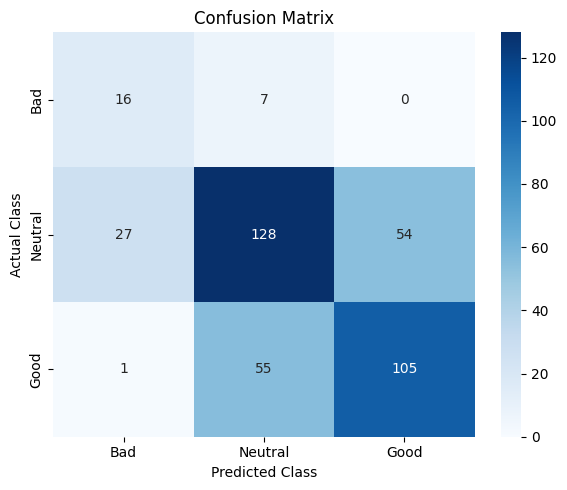

<module 'matplotlib.pyplot' from '/home/hendrik/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

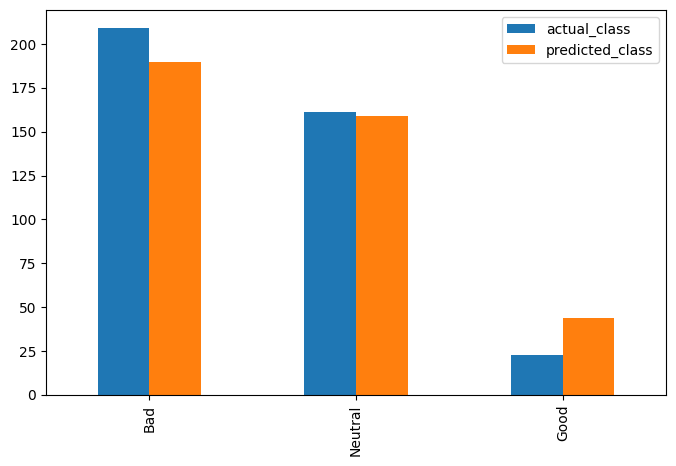

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Load the predictions with mood classes
df = pd.read_csv("mood_predictions_categorized.csv")

# Labels
mood_labels = ['Bad', 'Neutral', 'Good']

# Accuracy
acc = accuracy_score(df['actual_class'], df['predicted_class'])
print(f"✅ Classification Accuracy: {acc:.4f}")

# Classification report
print("\n📊 Classification Report:")
print(classification_report(df['actual_class'], df['predicted_class'], target_names=mood_labels))

# Confusion Matrix (numeric and labeled)
cm = confusion_matrix(df['actual_class'], df['predicted_class'])

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=mood_labels, yticklabels=mood_labels)
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Class distribution comparison (bar plot)
class_counts = df[['actual_class', 'predicted_class']].apply(pd.Series.value_counts).fillna(0)
class_counts.index = mood_labels

class_counts.plot(kind='bar', figsize=(8, 5))
plt


In [99]:
import matplotlib.pyplot as plt
import os

os.makedirs("user_plots", exist_ok=True)

for uid, values in user_results.items():
    pred_vals, actual_vals = zip(*values)

    # Plot and save per user
    plt.figure(figsize=(8, 4))
    plt.plot(pred_vals, label='Predicted', marker='o')
    plt.plot(actual_vals, label='Actual', marker='x')
    plt.title(f'User {uid} Mood Predictions')
    plt.xlabel('Sample Index')
    plt.ylabel('Mood')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"user_plots/user_{uid}_mood_plot.png")
    plt.close()


In [125]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

# Features
feature_cols = [
    'screen','call','sms','appCat.builtin','appCat.communication','appCat.entertainment',
    'appCat.finance','appCat.game','appCat.office','appCat.other','appCat.social',
    'appCat.travel','appCat.unknown','appCat.utilities','appCat.weather','activity',
    'circumplex.arousal','circumplex.valence','mood_count',
    'weekday','day','month','weekday_0','weekday_1','weekday_2',
    'weekday_3','weekday_4','weekday_5','weekday_6'
]

# Load dataset
df = pd.read_csv("daily_mov_featured.csv")

# Categorize mood into 3 classes
def categorize_mood(value):
    if value <= 0.6:                #0.58
        return 0  # Bad
    elif value <= 0.8:
        return 1  # Neutral
    else:
        return 2  # Good

df['mood_class'] = df['mood'].apply(categorize_mood)
target = 'mood_class'
user_col = 'user_id'

# Normalize features
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

# Encode user_id
df['user_id_idx'] = df[user_col].astype('category').cat.codes
num_users = df['user_id_idx'].nunique()

# Train/validation/test split
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

# PyTorch Dataset
class MoodDataset(Dataset):
    def __init__(self, dataframe):
        self.features = dataframe[feature_cols].values.astype('float32')
        self.moods = dataframe[target].values.astype('int64')
        self.user_ids = dataframe['user_id_idx'].values.astype('int64')

    def __len__(self):
        return len(self.moods)

    def __getitem__(self, idx):
        return {
            'features': torch.tensor(self.features[idx]),
            'user_id': torch.tensor(self.user_ids[idx]),
            'mood': torch.tensor(self.moods[idx]),
            'raw_user_id': int(self.user_ids[idx])
        }

# Create DataLoaders
train_loader = DataLoader(MoodDataset(train_df), batch_size=32, shuffle=True)
val_loader = DataLoader(MoodDataset(val_df), batch_size=32)
test_loader = DataLoader(MoodDataset(test_df), batch_size=32)

# Neural Network
class MoodNN(nn.Module):
    def __init__(self, input_dim, num_users, user_emb_dim=16):
        super(MoodNN, self).__init__()
        self.user_embedding = nn.Embedding(num_users, user_emb_dim)
        self.fc = nn.Sequential(
            nn.Linear(input_dim + user_emb_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32,3)
        )

    def forward(self, x, user_id):
        user_emb = self.user_embedding(user_id)
        x = torch.cat([x, user_emb], dim=1)
        return self.fc(x)

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.best_model_state = None

    def step(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

# ✅ Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Initialize model
model = MoodNN(input_dim=len(feature_cols), num_users=num_users).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# ✅ Compute class weights and define loss
class_labels = np.unique(df['mood_class'])
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=df['mood_class'])
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
loss_fn = nn.CrossEntropyLoss(weight=weights_tensor)

early_stopper = EarlyStopping(patience=5)

# ✅ Training loop
for epoch in range(100):
    model.train()
    total_loss = 0
    for batch in train_loader:
        x = batch['features'].to(device)
        user_id = batch['user_id'].to(device)
        y = batch['mood'].to(device)

        optimizer.zero_grad()
        pred = model(x, user_id)
        loss = loss_fn(pred, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        total_loss += loss.item()

    # ✅ Validation
    model.eval()
    val_preds, val_actuals = [], []
    with torch.no_grad():
        for batch in val_loader:
            x = batch['features'].to(device)
            user_id = batch['user_id'].to(device)
            y = batch['mood'].to(device)
            pred = model(x, user_id)
            val_preds.extend(torch.argmax(pred, dim=1).cpu().numpy())
            val_actuals.extend(y.cpu().numpy())

    val_acc = accuracy_score(val_actuals, val_preds)
    print(f"Epoch {epoch+1} - Train Loss: {total_loss / len(train_loader):.4f}, Val Accuracy: {val_acc:.4f}")

    if early_stopper.step(-val_acc, model):
        print("🛑 Early stopping triggered.")
        model.load_state_dict(early_stopper.best_model_state)
        break

# ✅ Evaluation
model.eval()
preds, actuals, user_ids = [], [], []
with torch.no_grad():
    for batch in test_loader:
        x = batch['features'].to(device)
        user_id = batch['user_id'].to(device)
        y = batch['mood'].to(device)
        raw_user_ids = batch['raw_user_id']
        pred = model(x, user_id)

        preds.extend(torch.argmax(pred, dim=1).cpu().numpy())
        actuals.extend(y.cpu().numpy())
        user_ids.extend(raw_user_ids)

preds = np.array(preds)
actuals = np.array(actuals)
user_ids = np.array(user_ids)

print(f"\n✅ Prediction count: {len(preds)}, Actual count: {len(actuals)}")

if len(preds) > 0:
    acc = accuracy_score(actuals, preds)
    print(f"\n✅ Test Classification Accuracy: {acc:.4f}")

    mood_labels = ['Bad', 'Neutral', 'Good']
    user_results = defaultdict(list)

    for uid, pred, actual in zip(user_ids, preds, actuals):
        user_results[uid].append((pred, actual))

    print("\n📊 Per-User Classification Accuracy:")
    for uid, values in user_results.items():
        pred_vals, actual_vals = zip(*values)
        acc = np.mean(np.array(pred_vals) == np.array(actual_vals))
        print(f"  User {uid}: Accuracy = {acc:.2f} ({len(values)} samples)")
        for i, (p, a) in enumerate(values):
            pred_label = mood_labels[p] if 0 <= p < len(mood_labels) else 'Unknown'
            actual_label = mood_labels[a] if 0 <= a < len(mood_labels) else 'Unknown'
            print(f"    Sample {i+1}: Predicted = {p} ({pred_label}), Actual = {a} ({actual_label})")
else:
    print("❌ No valid predictions to evaluate.")


Epoch 1 - Train Loss: 1.0845, Val Accuracy: 0.2429
Epoch 2 - Train Loss: 0.9569, Val Accuracy: 0.3714
Epoch 3 - Train Loss: 0.7495, Val Accuracy: 0.4762
Epoch 4 - Train Loss: 0.5980, Val Accuracy: 0.5810
Epoch 5 - Train Loss: 0.5340, Val Accuracy: 0.6333
Epoch 6 - Train Loss: 0.5528, Val Accuracy: 0.6524
Epoch 7 - Train Loss: 0.4882, Val Accuracy: 0.6571
Epoch 8 - Train Loss: 0.4570, Val Accuracy: 0.6952
Epoch 9 - Train Loss: 0.4240, Val Accuracy: 0.6714
Epoch 10 - Train Loss: 0.4120, Val Accuracy: 0.7048
Epoch 11 - Train Loss: 0.3764, Val Accuracy: 0.7048
Epoch 12 - Train Loss: 0.3649, Val Accuracy: 0.7190
Epoch 13 - Train Loss: 0.3419, Val Accuracy: 0.7381
Epoch 14 - Train Loss: 0.3532, Val Accuracy: 0.7381
Epoch 15 - Train Loss: 0.3576, Val Accuracy: 0.7048
Epoch 16 - Train Loss: 0.3093, Val Accuracy: 0.7524
Epoch 17 - Train Loss: 0.2898, Val Accuracy: 0.7524
Epoch 18 - Train Loss: 0.2699, Val Accuracy: 0.7524
Epoch 19 - Train Loss: 0.2881, Val Accuracy: 0.7286
Epoch 20 - Train Loss

In [119]:
import matplotlib.pyplot as plt
import os

# Create a directory to store user-specific plots
os.makedirs("user_classification_plots", exist_ok=True)

mood_labels = ['Bad', 'Neutral', 'Good']

for uid, values in user_results.items():
    pred_vals, actual_vals = zip(*values)

    # Create figure
    plt.figure(figsize=(10, 4))
    plt.plot(actual_vals, label="Actual", linestyle='-', marker='o')
    plt.plot(pred_vals, label="Predicted", linestyle='--', marker='x')
    plt.title(f"User {uid} - Mood Class Predictions")
    plt.xlabel("Sample Index")
    plt.ylabel("Mood Class")
    plt.yticks(ticks=[0, 1, 2], labels=mood_labels)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"user_classification_plots/user_{uid}_mood_class.png")
    plt.close()


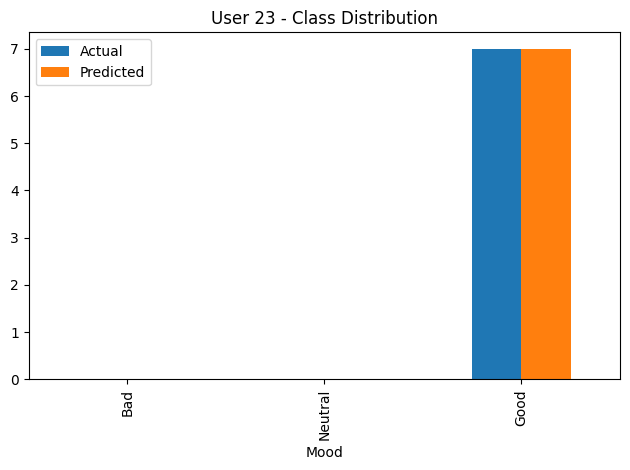

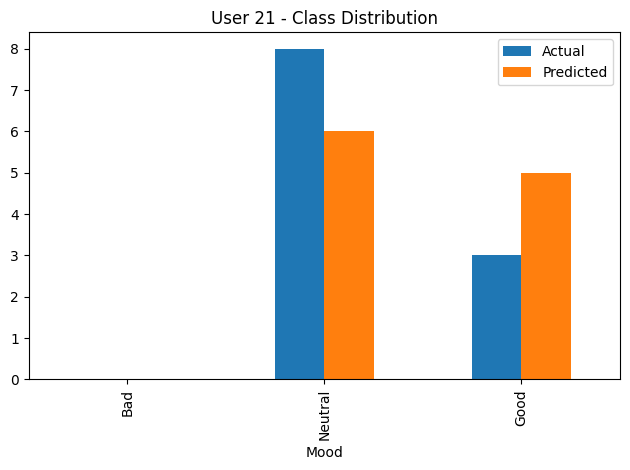

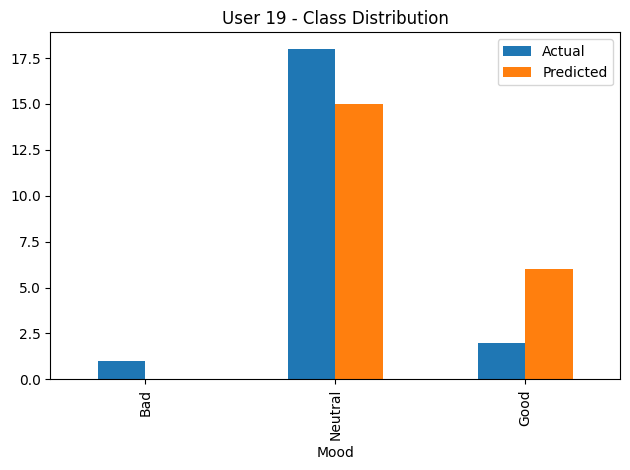

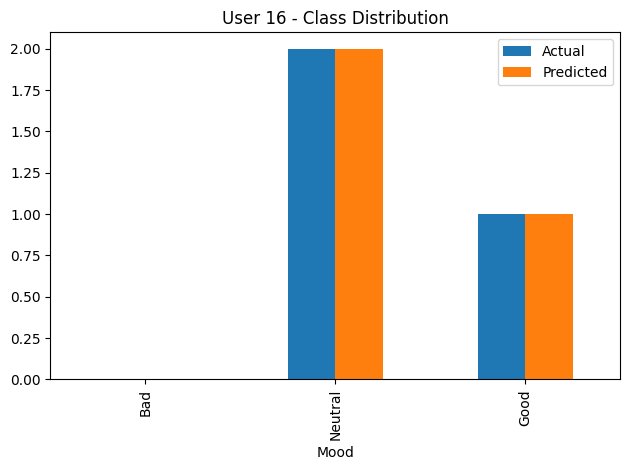

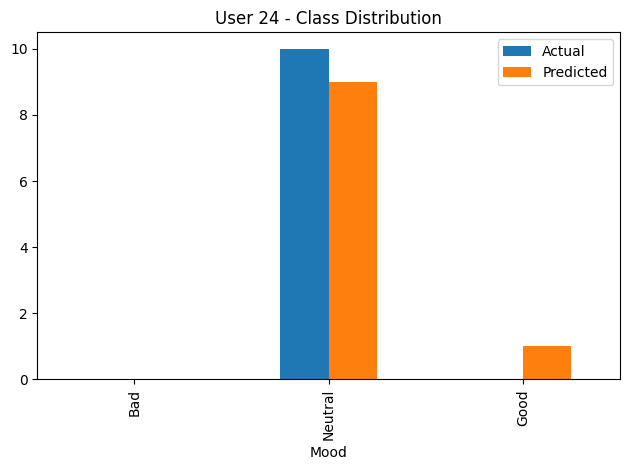

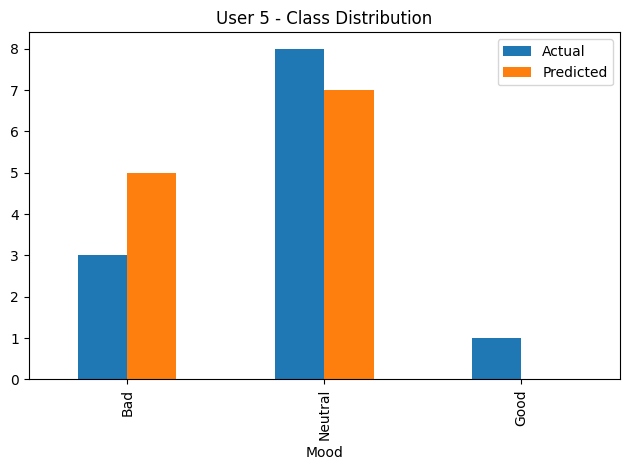

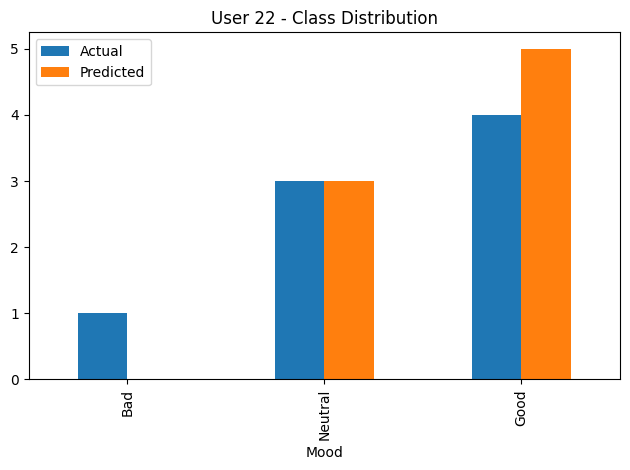

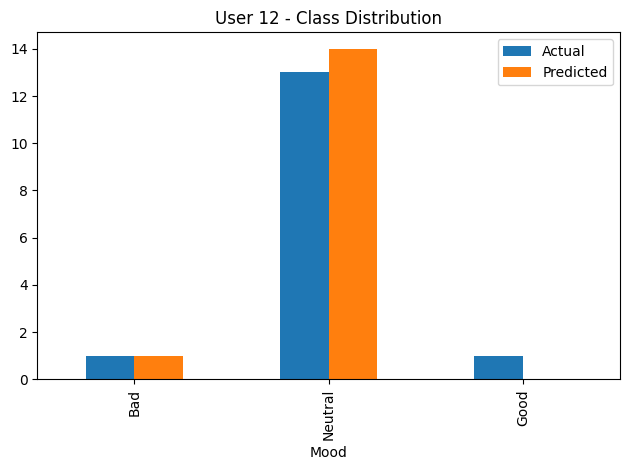

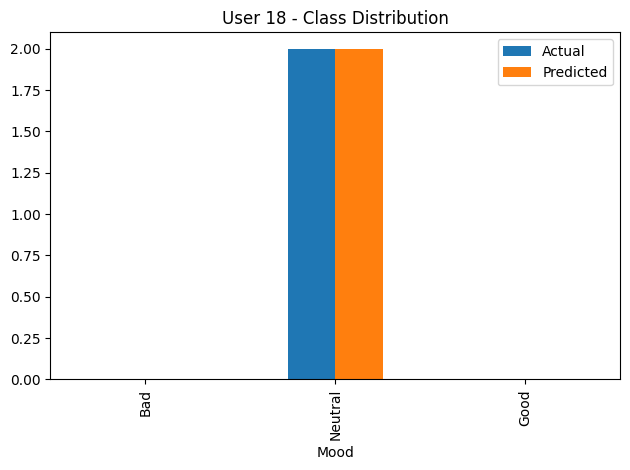

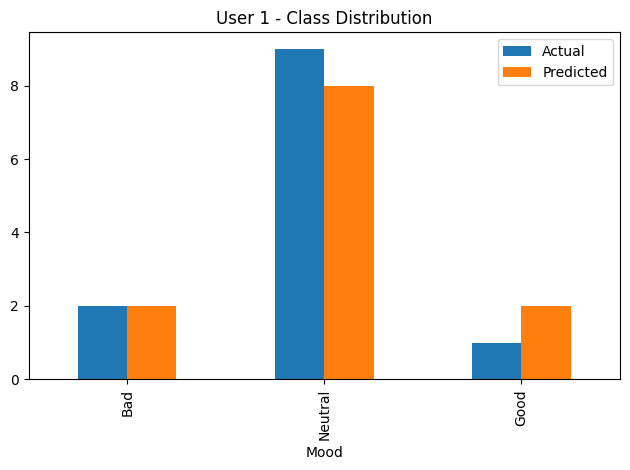

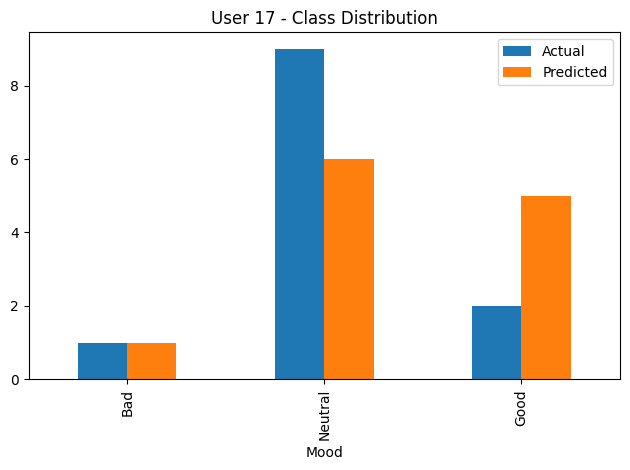

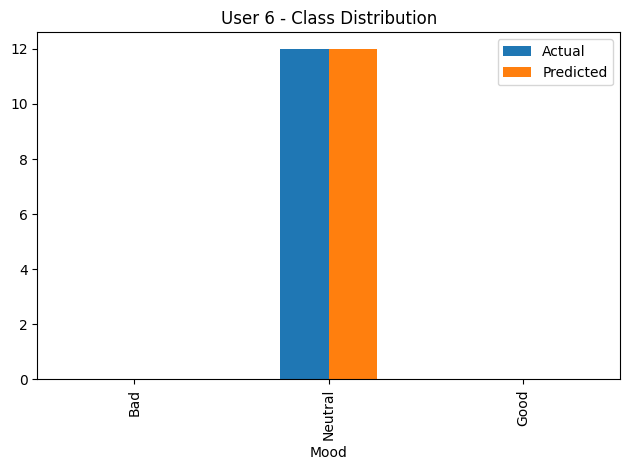

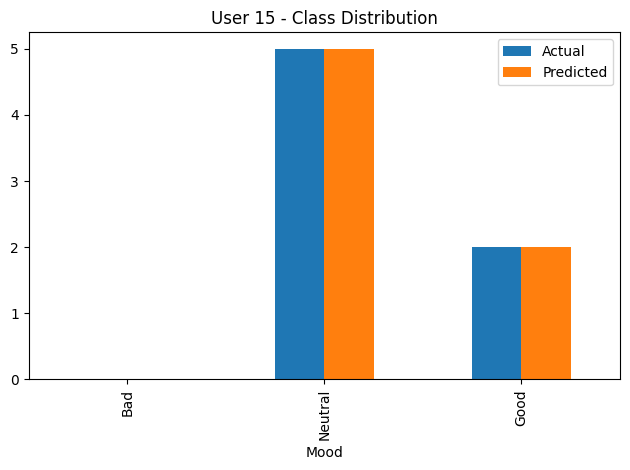

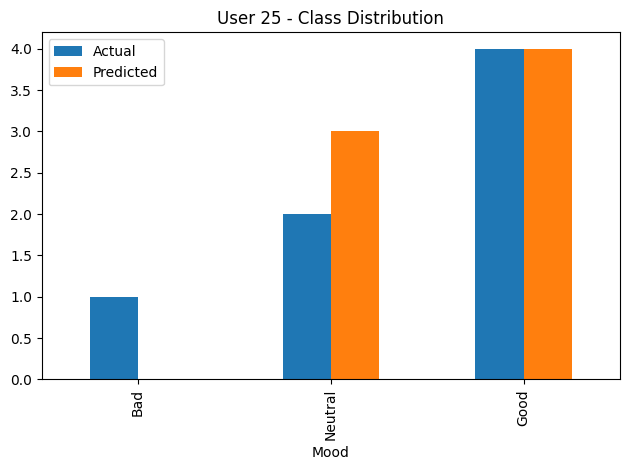

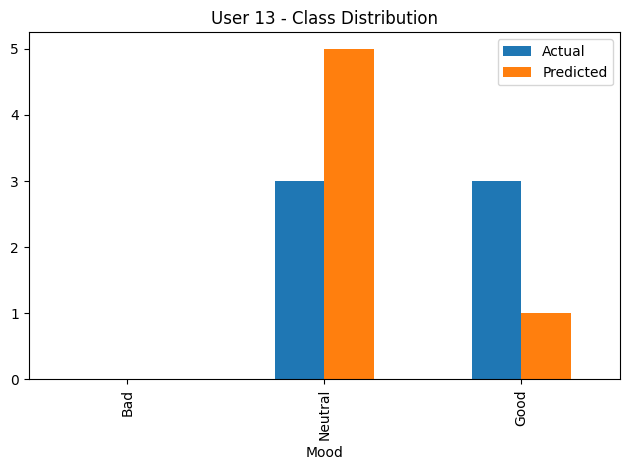

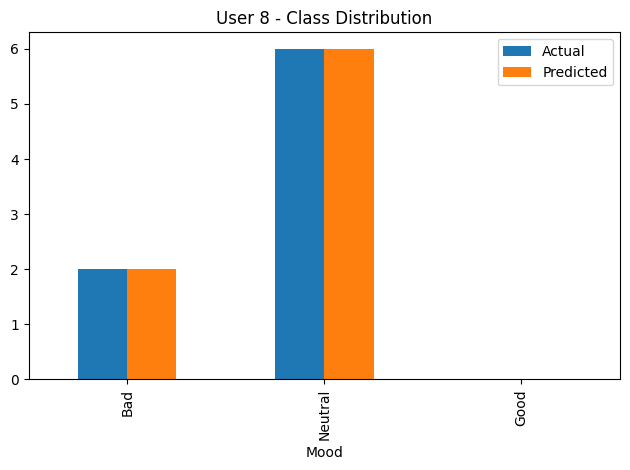

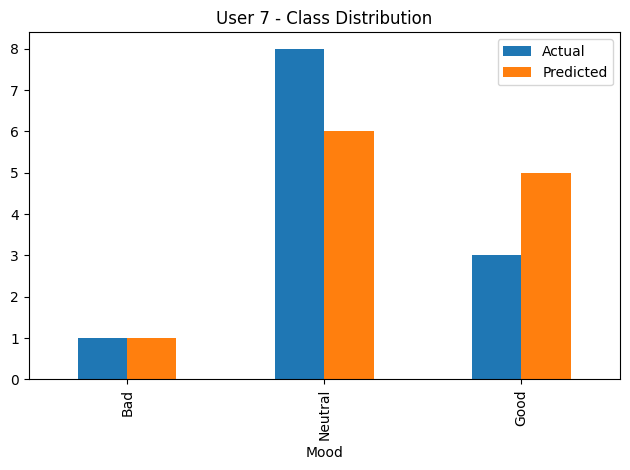

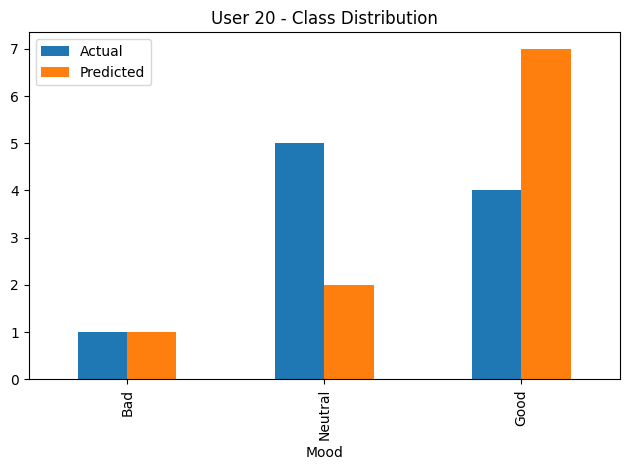

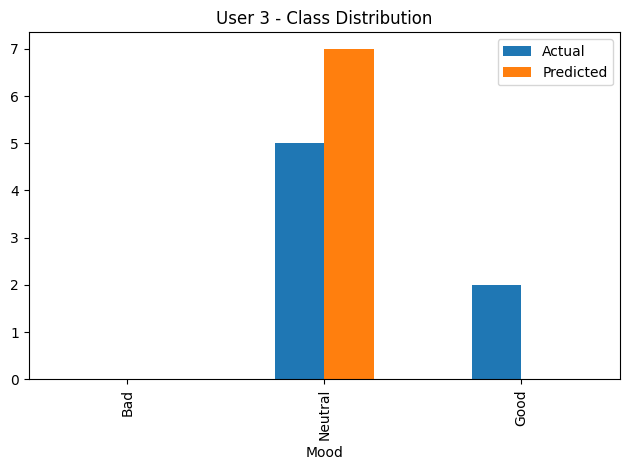

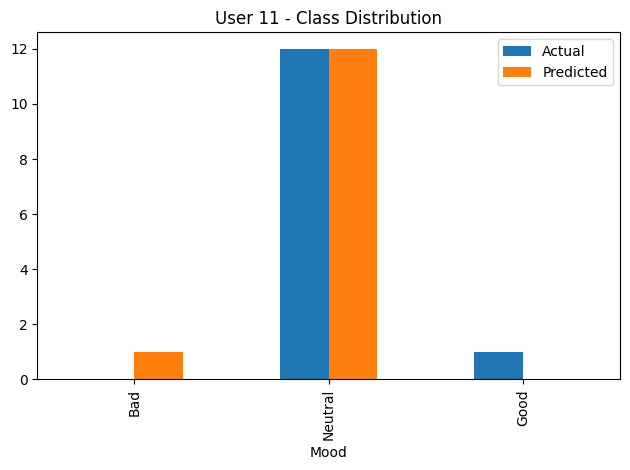

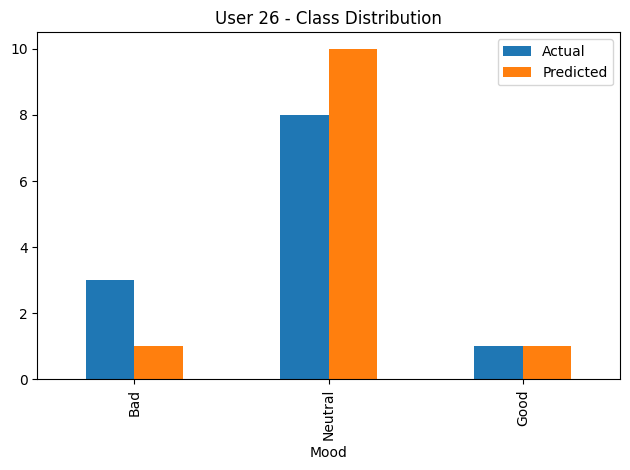

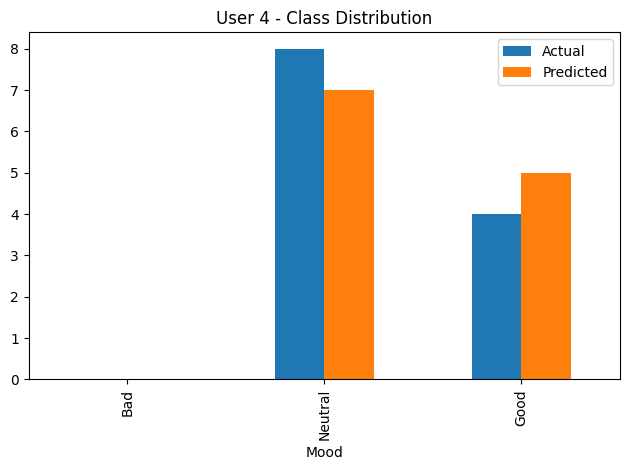

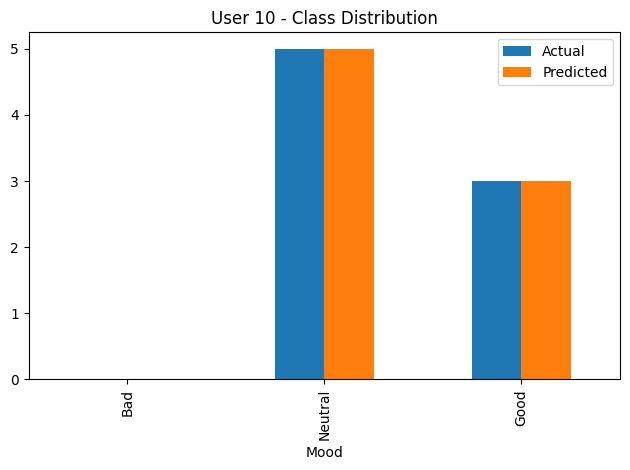

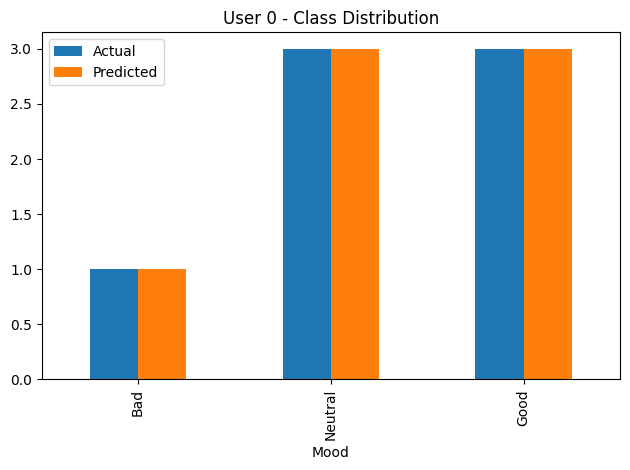

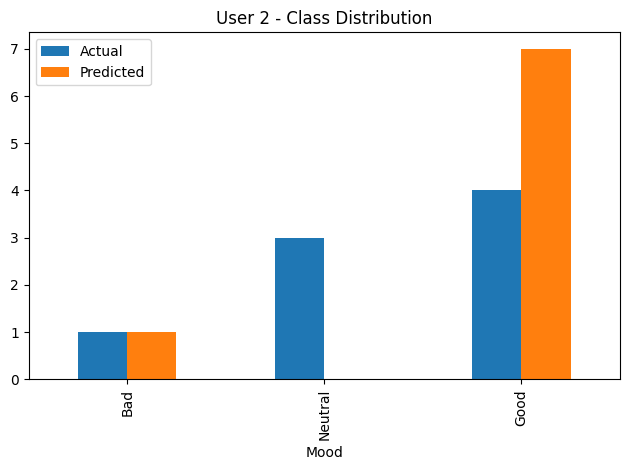

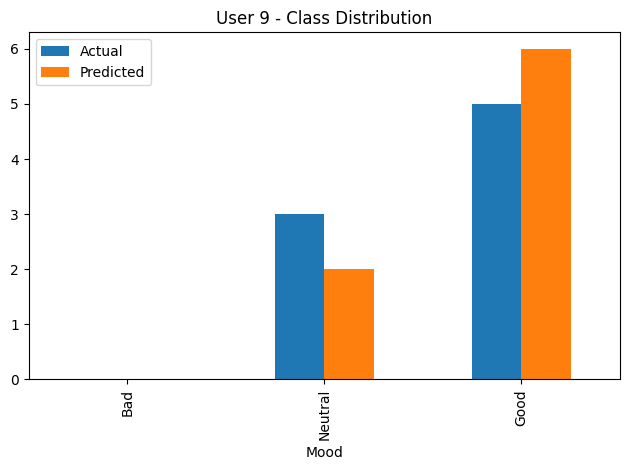

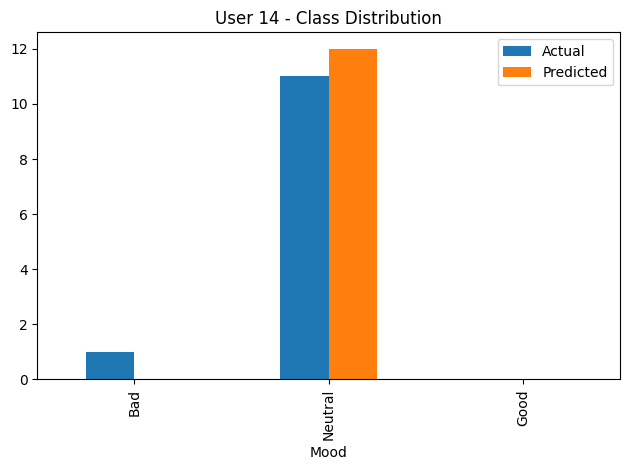

In [120]:
import seaborn as sns
from collections import Counter

for uid, values in user_results.items():
    pred_vals, actual_vals = zip(*values)
    count_actual = Counter(actual_vals)
    count_pred = Counter(pred_vals)
    data = pd.DataFrame({
        'Mood': ['Bad', 'Neutral', 'Good'],
        'Actual': [count_actual.get(i, 0) for i in range(3)],
        'Predicted': [count_pred.get(i, 0) for i in range(3)]
    })
    data.set_index('Mood').plot(kind='bar', title=f"User {uid} - Class Distribution")
    plt.tight_layout()
    plt.show()


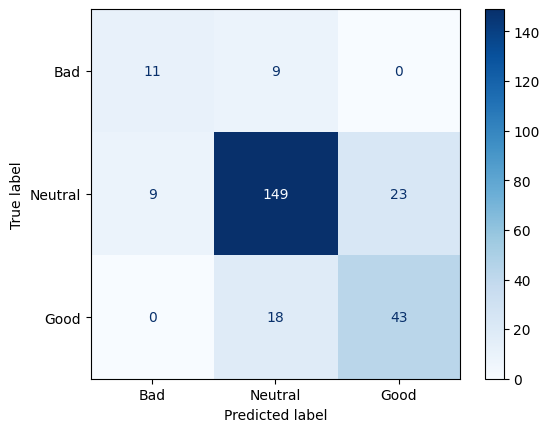

In [126]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(actuals, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bad', 'Neutral', 'Good'])
disp.plot(cmap="Blues")



📊 Per-User Confusion Matrices:

User 23


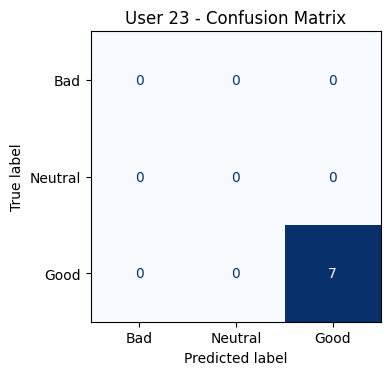


User 21


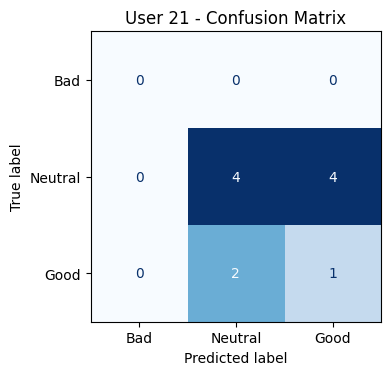


User 19


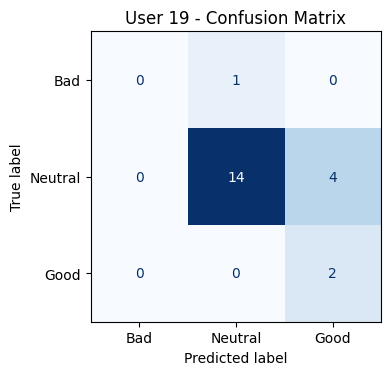


User 16


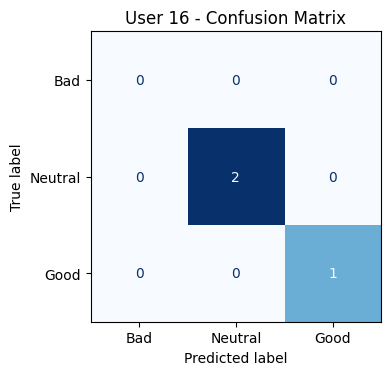


User 24


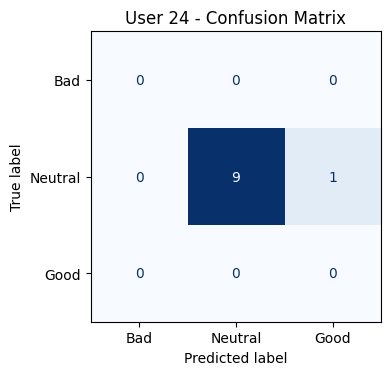


User 5


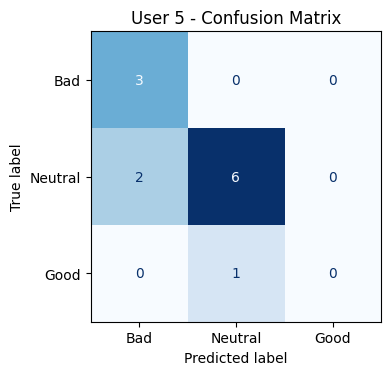


User 22


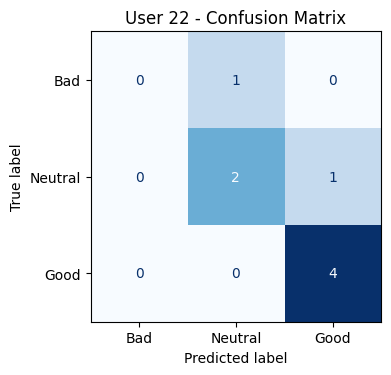


User 12


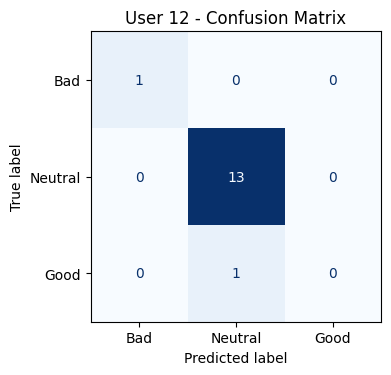


User 18


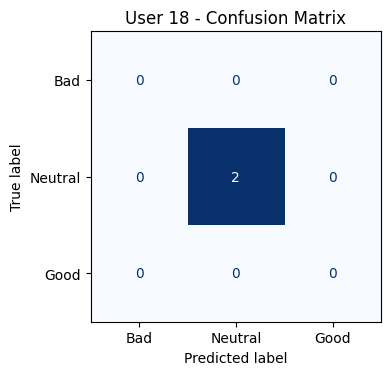


User 1


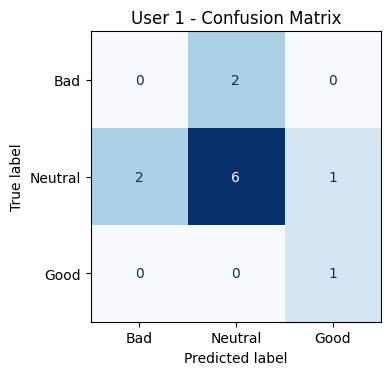


User 17


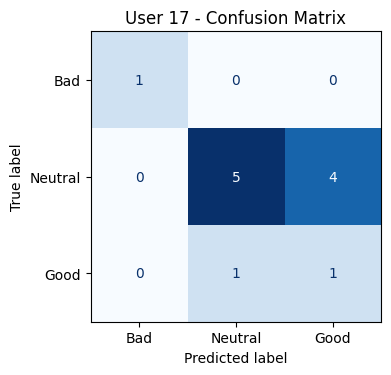


User 6


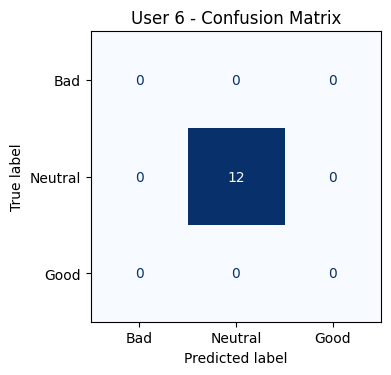


User 15


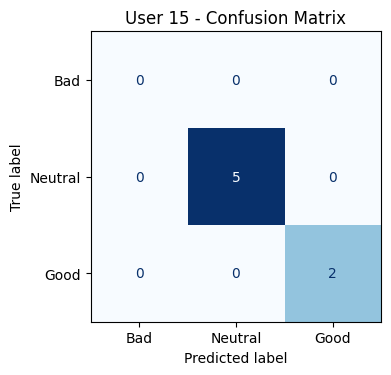


User 25


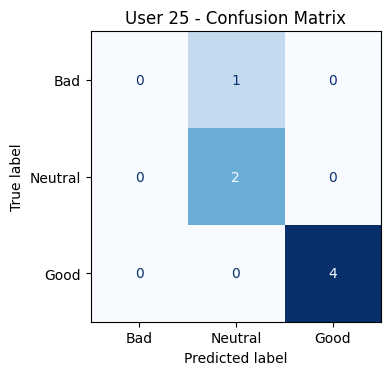


User 13


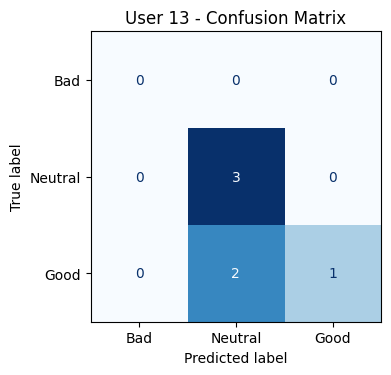


User 8


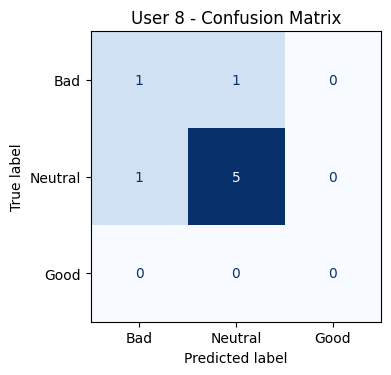


User 7


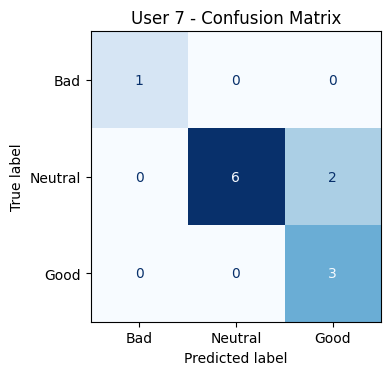


User 20


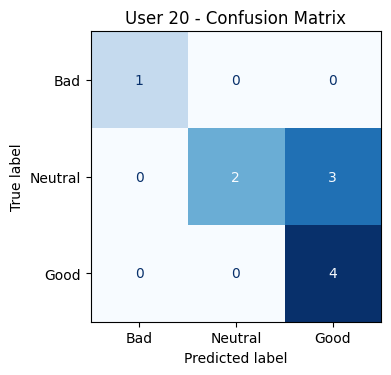


User 3


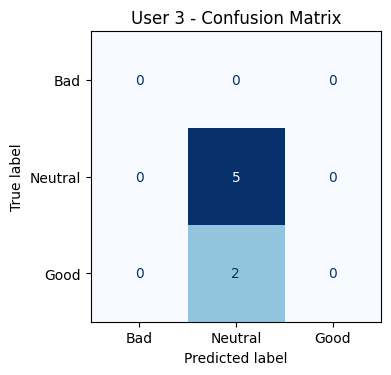


User 11


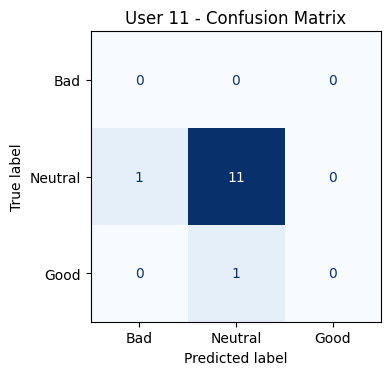


User 26


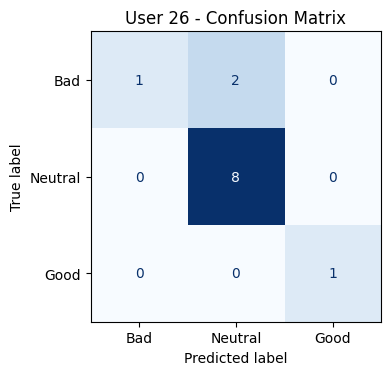


User 4


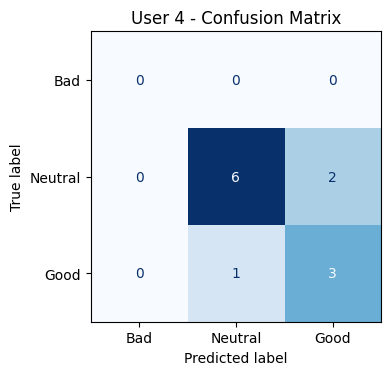


User 10


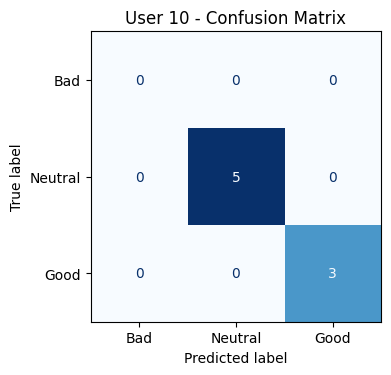


User 0


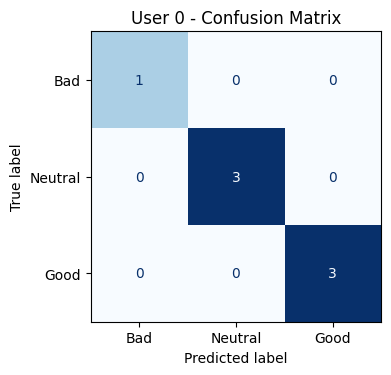


User 2


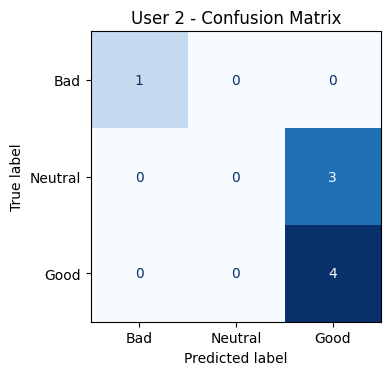


User 9


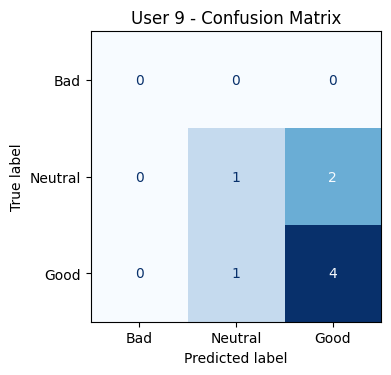


User 14


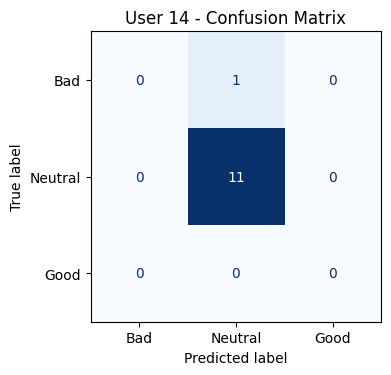

In [122]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

mood_labels = ['Bad', 'Neutral', 'Good']

print("\n📊 Per-User Confusion Matrices:")

for uid, values in user_results.items():
    pred_vals, actual_vals = zip(*values)
    cm = confusion_matrix(actual_vals, pred_vals, labels=[0, 1, 2])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mood_labels)

    print(f"\nUser {uid}")
    fig, ax = plt.subplots(figsize=(4, 4))
    disp.plot(ax=ax, cmap='Blues', values_format='d', colorbar=False)
    plt.title(f"User {uid} - Confusion Matrix")
    plt.tight_layout()
    plt.show()
